# SI 618: Data Manipulation and Analysis
## 10 - Dimension Reduction
### Dr. Chris Teplovs, School of Information, University of Michigan
<small><a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a> This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

### [Dimension Reduction slides](resources/si618-dimensionality-reduction.pdf)

Overall:

* Run factor analysis if you assume or wish to test a theoretical model of latent factors causing observed variables.

* Run principal component analysis If you want to simply reduce your correlated observed variables to a smaller set of important independent composite variables.

--Jeromy Anglim

# Analysis 1 (Heptathalon)

* Be able to perform principcal component analysis (PCA) and exploratory factor analysis (EFA).
* Be able to apply manifold learning methods, including multidimensional scaling (MDS)



In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set_context("notebook")  # make figures fit
from pylab import rcParams
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from IPython.display import Image
from IPython.core.display import HTML 
import sklearn as sk
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.manifold as skm
import sklearn.preprocessing as skp

# Load the Data


In [51]:
df_hept = pd.read_csv('data/heptathlon.csv')
df_hept = df_hept.set_index('Athlete')
df_hept.head()

,Hurdles,HighJump,Shot,Run200m,LongJump,Javelin,Run800m,Score
Athlete,,,,,,,,
Joyner-Kersee (USA),12.69,1.86,15.80,22.56,7.27,45.66,128.51,7291
John (GDR),12.85,1.80,16.23,23.65,6.71,42.56,126.12,6897
Behmer (GDR),13.20,1.83,14.20,23.10,6.68,44.54,124.20,6858
Sablovskaite (URS),13.61,1.80,15.23,23.92,6.25,42.78,132.24,6540
Choubenkova (URS),13.51,1.74,14.76,23.93,6.32,47.46,127.90,6540


In [52]:
# Let's print out summary information to check the data quality 
# and structure.
df_hept.describe()

,Hurdles,HighJump,Shot,Run200m,LongJump,Javelin,Run800m,Score
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,13.840000,1.782000,13.117600,24.649200,6.152400,41.482400,136.054000,6090.600000
std,0.736648,0.077942,1.491884,0.969557,0.474212,3.545656,8.291088,568.469729
min,12.690000,1.500000,10.000000,22.560000,4.880000,35.680000,124.200000,4566.000000
25%,13.470000,1.770000,12.320000,23.920000,6.050000,39.060000,132.240000,5746.000000
50%,13.750000,1.800000,12.880000,24.830000,6.250000,40.280000,134.740000,6137.000000
75%,14.070000,1.830000,14.200000,25.230000,6.370000,44.540000,138.480000,6351.000000
max,16.420000,1.860000,16.230000,26.610000,7.270000,47.500000,163.430000,7291.000000


# Question: Should "score" be included in these analyses?

For now, let's omit the "score" column

In [53]:
df_hept.drop('Score',inplace=True, axis=1)

## 2.1 Rescaling the Data
Let us normalize the data by computing the "[z-scores](https://en.wikipedia.org/wiki/Standard_score#Calculation_from_raw_score)" of the values. This step of normalization (rescaling) is important to PCA.

Given a column x, the z-scores of the elements in x is simply

    (x - mean(x)) / std(x)
    
where, `std` means standard deviation.

In [49]:
df_hept_norm = df_hept.copy()
df_hept_norm.ix[:,:7] = skp.scale(df_hept_norm.ix[:,:7].astype(np.float))
df_hept_norm.head()

,Hurdles,HighJump,Shot,Run200m,LongJump,Javelin,Run800m,pc1,pc2
Athlete,,,,,,,,,
Joyner-Kersee (USA),-1.593317,1.021376,1.835071,-2.199232,2.405348,1.202526,-0.928655,-4.206435,1.268024
John (GDR),-1.371639,0.235702,2.129240,-1.051825,1.200091,0.310188,-1.222861,-2.941619,0.534526
Behmer (GDR),-0.886716,0.628539,0.740486,-1.630792,1.135524,0.880133,-1.459210,-2.704271,0.692759
Sablovskaite (URS),-0.318663,0.235702,1.445125,-0.767605,0.210059,0.373515,-0.469498,-1.371052,0.706559
Choubenkova (URS),-0.457213,-0.549972,1.123591,-0.757078,0.360716,1.720658,-1.003745,-1.387050,1.789317


In [11]:
# confirm the mean/std are 0/1
df_hept_norm.describe()

,Hurdles,HighJump,Shot,Run200m,LongJump,Javelin,Run800m
count,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,25.000000
mean,2.131628e-16,3.055334e-15,3.463896e-16,-4.352074e-16,-2.486900e-16,-1.589839e-15,0.000000
std,1.020621e+00,1.020621e+00,1.020621e+00,1.020621e+00,1.020621e+00,1.020621e+00,1.020621
min,-1.593317e+00,-3.692669e+00,-2.132797e+00,-2.199232e+00,-2.738515e+00,-1.670227e+00,-1.459210
25%,-5.126326e-01,-1.571348e-01,-5.456503e-01,-7.676047e-01,-2.203898e-01,-6.972903e-01,-0.469498
50%,-1.246944e-01,2.357023e-01,-1.625458e-01,1.903222e-01,2.100590e-01,-3.461121e-01,-0.161751
75%,3.186635e-01,6.285394e-01,7.404863e-01,6.113890e-01,4.683283e-01,8.801333e-01,0.298637
max,3.574573e+00,1.021376e+00,2.129240e+00,2.064069e+00,2.405348e+00,1.732172e+00,3.369945


# 1. Multidimensional Scaling (MDS)
MDS seeks a low-dimensional representation of the data that preserves the distances in the high-dimensional space. It can take any kind of distance matrix as input.

Note that each time you run MDS, you will get a different result, unless `random_state` is fixed.

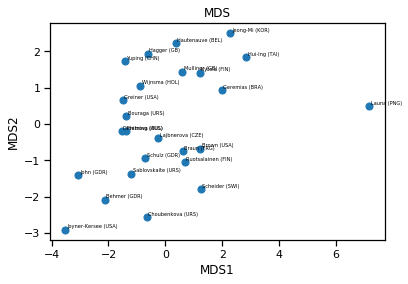

In [12]:
# Use MDS to visualize brands.
# Recall that df_bybrand is the mean-metric-by-brand 
# we created above.
X = skm.MDS(n_components=2).fit_transform(df_hept_norm)
plt.scatter(X[:,0],X[:,1],s=50)

plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.title('MDS')

for i, s in enumerate(df_hept_norm.index):
    plt.annotate(s, xy=X[i,:2]+0.05, fontsize=5)

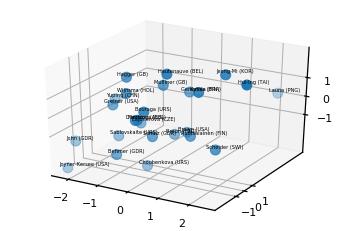

In [13]:
# We can also create 3d scatterplots.
X = skm.MDS(n_components=3).fit_transform(df_hept_norm)

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], s=100)

ax.set_xticks([-2,-1,0,1,2])
ax.set_yticks([-1,0,1])
ax.set_zticks([-1,0,1])

for i, s in enumerate(df_hept_norm.index):
    x, y, _ = proj3d.proj_transform(X[i,0],X[i,1],X[i,2],
                                    ax.get_proj())
    plt.annotate(s, xy=(x-0.005,y+0.002), fontsize=5)

# 2. Bivariate Analysis (Quick Review)


## 2.2 Bivariate Analysis
For initial inspection of bivariate relationships among the variables, let us create a correlation plot.

In [14]:
# test for correlations
df_hept_norm.corr()

,Hurdles,HighJump,Shot,Run200m,LongJump,Javelin,Run800m
Hurdles,1.000000,-0.811403,-0.651335,0.773721,-0.912134,-0.007763,0.779257
HighJump,-0.811403,1.000000,0.440786,-0.487664,0.782442,0.002153,-0.591163
Shot,-0.651335,0.440786,1.000000,-0.682670,0.743073,0.268989,-0.419620
Run200m,0.773721,-0.487664,-0.682670,1.000000,-0.817205,-0.333043,0.616810
LongJump,-0.912134,0.782442,0.743073,-0.817205,1.000000,0.067108,-0.699511
Javelin,-0.007763,0.002153,0.268989,-0.333043,0.067108,1.000000,0.020049
Run800m,0.779257,-0.591163,-0.419620,0.616810,-0.699511,0.020049,1.000000


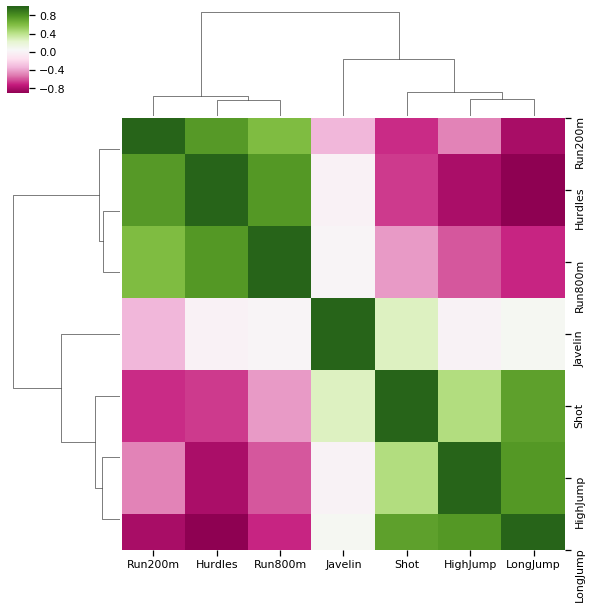

In [17]:
# draw a "clustered" heatmap
sns.clustermap(df_hept_norm.corr(),cmap=plt.cm.PiYG)

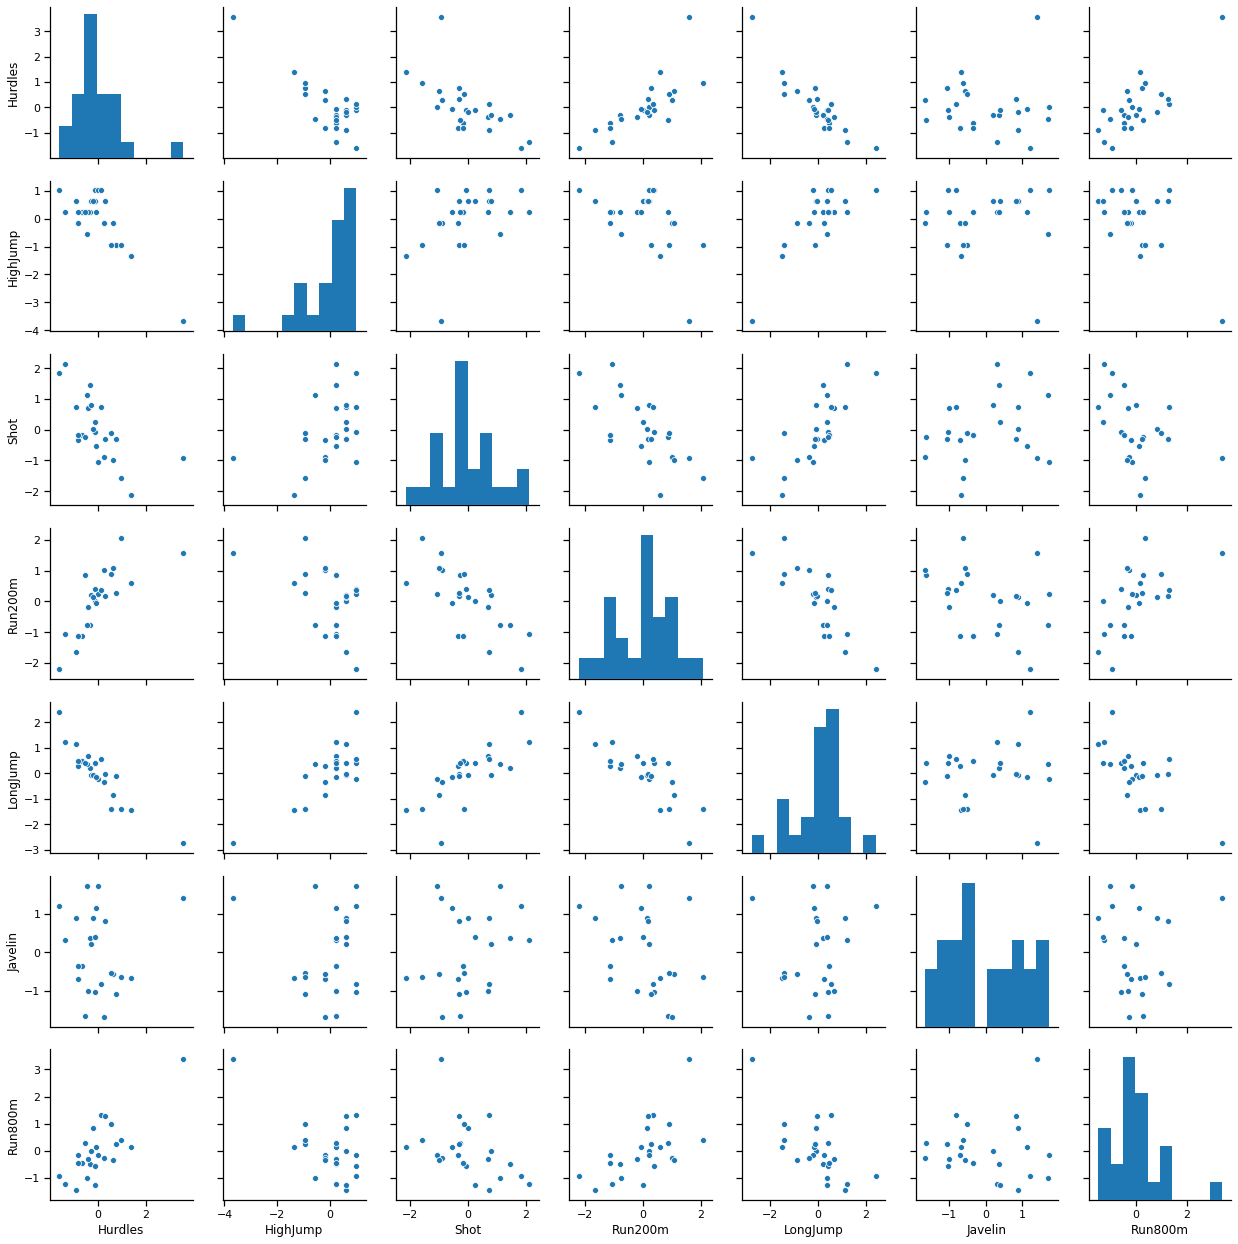

In [16]:
# pairplot
sns.pairplot(df_hept_norm)

# 2. Principal Component Analysis

We have demonstrated how to use principal component analysis (PCA) to do dimensionality reduction for visualization in the previous lab. Now let us look at PCA in greater details.

In [20]:
# Create a PCA model
pca_model = skd.PCA().fit(df_hept_norm.ix[:,:])

In [21]:
# There are 7 components extracted from the data; each component is
# a 7-dimensional vector.
pca_model.components_.shape

(7, 7)

In [21]:
# Look at the variances explained by each component.
# These values equal to the eigenvalues of the correlation matrix.
pca_model.explained_variance_

array([4.64611996, 1.24408391, 0.54272305, 0.47621544, 0.25548619,
       0.0759954 , 0.05104272])

One way of determining the number of principal components to retain is to look at the explained variance as shown above, and drop those principal components whose explained variance is smaller than 1.

Another way is to create a __Scree Plot__ as below, and find the "elbow" point on the plotted curve.

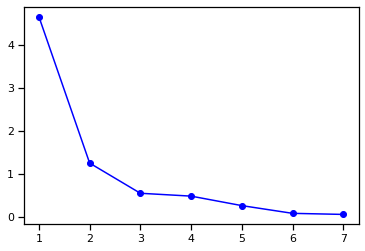

In [22]:
# A "scree" plot.
plt.plot(range(1,8),pca_model.explained_variance_,'b-o')

Next we will create a __biplot__, which is 2-D scatterplot showing all the data points as well as the data variables in the space defined by the first two principal components.

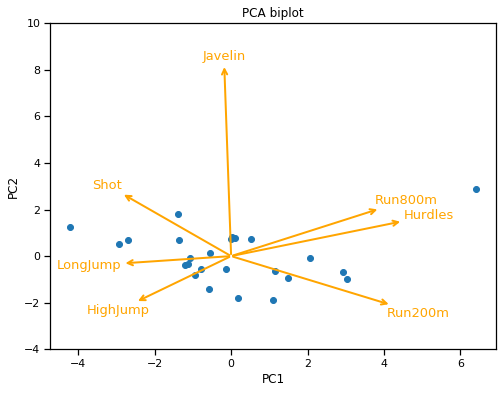

In [26]:
# Scatterplot of disaggregated data
X = pca_model.transform(df_hept_norm.ix[:,:7])
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA biplot')
plt.ylim(-4, 10)

# Add variable unit vector projections
V = pca_model.transform(np.identity(X.shape[1]))
for i, v in enumerate(V):
    plt.annotate(df_hept_norm.columns[i], 
                 xy=(0,0), xytext=v[:2]*10, 
                 fontsize=13, color='orange',
                 arrowprops=dict(
                    arrowstyle='<-', linewidth=2, color='orange'))

### <font color="magenta">Q1: What's the correlation between PC1 and *Score* from the original data?</font>

In [31]:
# score with first component 
X[:,0]

array([-4.20643487e+00, -2.94161870e+00, -2.70427114e+00, -1.37105209e+00,
       -1.38704979e+00, -1.06537236e+00, -1.12307639e+00, -9.42210150e-01,
       -5.41184843e-01, -7.75487044e-01, -5.67738958e-01, -1.21091937e+00,
        1.57800481e-02,  3.85204977e-03,  9.26189926e-02, -1.40055128e-01,
        1.74657449e-01,  5.29960012e-01,  1.14869009e+00,  1.10808552e+00,
        1.47689483e+00,  2.05556037e+00,  2.93969248e+00,  3.03136461e+00,
        6.39931438e+00])

In [32]:
# score with second component 
X[:,1]

array([ 1.26802363,  0.53452561,  0.69275901,  0.70655862,  1.78931718,
       -0.08104469, -0.33042906, -0.82345074,  0.14933917, -0.53686251,
       -1.42507414, -0.36106077,  0.82307249,  0.7295375 ,  0.77877955,
       -0.54831883, -1.77914066,  0.7419553 , -0.64788023, -1.88531477,
       -0.94353198, -0.09495979, -0.67514662, -0.97939889,  2.89774561])

In [43]:
df_hept['pc1'] = X[:,0]
df_hept['pc2'] = X[:,1]

In [44]:
df_hept.corr()

,Hurdles,HighJump,Shot,Run200m,LongJump,Javelin,Run800m,Score,pc1,pc2
Hurdles,1.000000,-0.811403,-0.651335,0.773721,-0.912134,-0.007763,0.779257,-0.923198,9.564348e-01,1.725835e-01
HighJump,-0.811403,1.000000,0.440786,-0.487664,0.782442,0.002153,-0.591163,0.767359,-7.966208e-01,-2.711075e-01
Shot,-0.651335,0.440786,1.000000,-0.682670,0.743073,0.268989,-0.419620,0.799699,-7.667860e-01,3.162788e-01
Run200m,0.773721,-0.487664,-0.682670,1.000000,-0.817205,-0.333043,0.616810,-0.864883,8.614484e-01,-2.845622e-01
LongJump,-0.912134,0.782442,0.743073,-0.817205,1.000000,0.067108,-0.699511,0.950437,-9.635326e-01,-6.106182e-02
Javelin,-0.007763,0.002153,0.268989,-0.333043,0.067108,1.000000,0.020049,0.253147,-1.592590e-01,9.198430e-01
Run800m,0.779257,-0.591163,-0.419620,0.616810,-0.699511,0.020049,1.000000,-0.772776,7.918903e-01,2.453337e-01
Score,-0.923198,0.767359,0.799699,-0.864883,0.950437,0.253147,-0.772776,1.000000,-9.910978e-01,9.788578e-02
pc1,0.956435,-0.796621,-0.766786,0.861448,-0.963533,-0.159259,0.791890,-0.991098,1.000000e+00,-1.847142e-16
pc2,0.172583,-0.271107,0.316279,-0.284562,-0.061062,0.919843,0.245334,0.097886,-1.847142e-16,1.000000e+00


__(YOUR INTERPRETATION HERE)__

# 3. Factor Analysis

We didn't cover factor analysis in class but it is in the readings. Factor analysis is similar to PCA but we have a little bit more control over the factors and how they relate to each other.

Below, we'll create 3 factors for the events and then print out their loadings.  That tells us how much each event contributs to each factor.

In [54]:
# Create a three-factor model
fa_model = skd.FactorAnalysis(n_components=3) \
              .fit(df_hept_norm.ix[:,:7])

# Show the loadings
df_loadings = pd.DataFrame(fa_model.components_[:3,:].T, 
                   index=df_hept.columns,
                   columns=['Factor1', 'Factor2', 'Factor3'])
df_loadings

,Factor1,Factor2,Factor3
Hurdles,0.951275,0.187302,0.109397
HighJump,-0.763002,-0.446091,0.050968
Shot,-0.732991,0.160497,0.303633
Run200m,0.885045,-0.403132,0.056832
LongJump,-0.964212,-0.076056,0.140774
Javelin,-0.129255,0.511201,0.092702
Run800m,0.750836,0.151658,0.308775


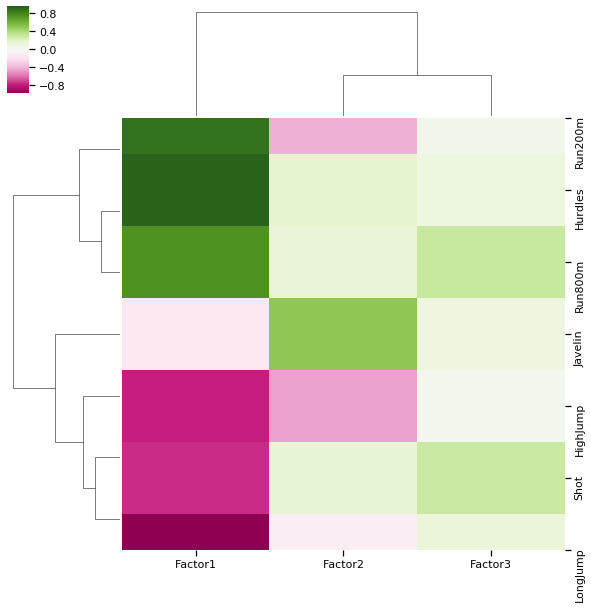

In [56]:
# Visualize the factor loading matrix
sns.clustermap(df_loadings,cmap='PiYG')

If you read down Factor 1 you can see that Hurdles, Run200m and Run800m seem to have high loadings.  We might name this the "running" factor.  Factor 3 has relatively high values for the jumping events.  Factor 2 is a bit of a mishmash.  We see high values for shot and javelin, which makes sense, but also for Run800m.  We might not have a great story for this.  Given our experience with PCA above we might try a two factor model instead.

In [57]:
# Create a three-factor model
fa_model = skd.FactorAnalysis(n_components=2) \
              .fit(df_hept_norm.ix[:,:7])

# Show the loadings
df_loadings = pd.DataFrame(fa_model.components_[:2,:].T, 
                   index=df_hept.columns,
                   columns=['Factor1', 'Factor2'])
df_loadings

,Factor1,Factor2
Hurdles,0.956422,0.173830
HighJump,-0.769389,-0.433264
Shot,-0.721458,0.186360
Run200m,0.877247,-0.401455
LongJump,-0.953748,-0.051143
Javelin,-0.126044,0.508433
Run800m,0.756286,0.140128


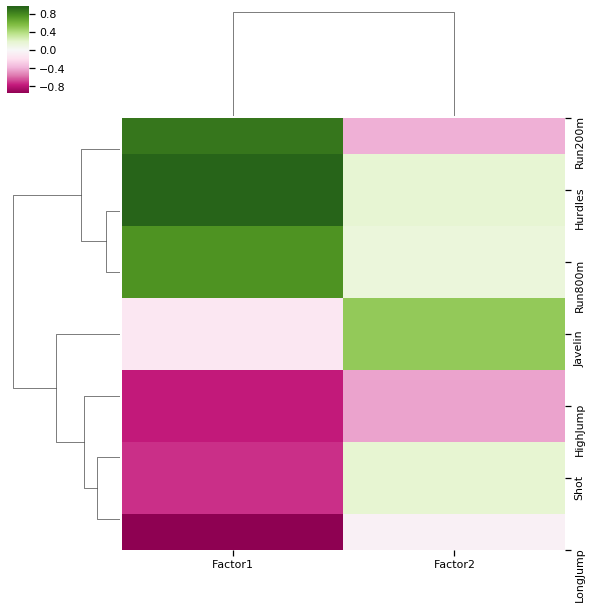

In [60]:
# Visualize the factor loading matrix
sns.clustermap(df_loadings,cmap='PiYG')

# Analysis 2 (Products)





In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set_context("notebook")  # make figures fit
from pylab import rcParams
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from IPython.display import Image
from IPython.core.display import HTML 
import sklearn as sk
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.manifold as skm
import sklearn.preprocessing as skp



# 1. Bivariate Analysis (Quick Review)

In this lab, we will mostly follow the analytic procedure in the following book chapter:

> Chapman and Feit, "Reducing Data Complexity", _R for Marketing Research and Analytics_, Chapter 8, (2015).

Many of the text descriptions below are taken from this chapter. Of course, you will see example code given in python instead of R. We will use the dataset in the book, customer brand perception surveys. For exercise questions, you will work on the iris dataset.

This section involves data importing and some descriptive analysis, serving as a quick review of previous weeks.

In [62]:
# Loads dataframe from a remote URL
df_survey = pd.read_csv('data/products.csv')
df_survey.head()

,perform,leader,latest,fun,serious,bargain,value,trendy,rebuy,brand
0,2,4,8,8,2,9,7,4,6,a
1,1,1,4,7,1,1,1,2,2,a
2,2,3,5,9,2,9,5,1,6,a
3,1,6,10,8,3,4,5,2,1,a
4,1,1,5,8,1,9,9,1,1,a


In [63]:
# Let's print out summary information to check the data quality 
# and structure.
df_survey.describe()

,perform,leader,latest,fun,serious,bargain,value,trendy,rebuy
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,4.488000,4.417000,6.195000,6.06800,4.323000,4.259000,4.33700,5.220000,3.727000
std,3.203454,2.608432,3.078059,2.74425,2.778199,2.667027,2.39858,2.742101,2.544592
min,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000
25%,1.000000,2.000000,4.000000,4.00000,2.000000,2.000000,2.00000,3.000000,1.000000
50%,4.000000,4.000000,7.000000,6.00000,4.000000,4.000000,4.00000,5.000000,3.000000
75%,7.000000,6.000000,9.000000,8.00000,6.000000,6.000000,6.00000,7.000000,5.000000
max,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.00000,10.000000,10.000000


In [64]:
# Let's check how many records we have per brand.
df_survey.brand.value_counts()

i    100
f    100
a    100
h    100
e    100
j    100
g    100
b    100
d    100
c    100
Name: brand, dtype: int64

Based on the above summary information, we can tell that the data are clean and are formatted appropriately.

## 1.2 Rescaling the Data
Let us normalize the data by computing the "[z-scores](https://en.wikipedia.org/wiki/Standard_score#Calculation_from_raw_score)" of the values. This step of normalization (rescaling) is important to PCA.

Given a column x, the z-scores of the elements in x is simply

    (x - mean(x)) / std(x)
    
where, `std` means standard deviation.

### <font color="magenta">Q2. Rescale the data</font>

In [33]:
df_survey_norm = df_survey.copy()

## YOUR CODE HERE ##

After rescaling (normalization), the means of all columns are all technically 0, and standard deviation 1.0.

## 1.3 Bivariate Analysis
For initial inspection of bivariate relationships among the variables, let us create a correlation plot.

### <font color="magenta">Q3. Create a clustermap. What do you see?</font>
- Can you identify the clusters of variables from the plot?

In [34]:
### YOUR CODE HERE ###

__(YOUR INTERPRETATION HERE)__

## By-Brand Analysis
We are going combine all products from one manufacturer into a row (based on the mean score)

In [35]:
df_bybrand = df_survey_norm.groupby('brand').mean()
df_bybrand.head()

,perform,leader,latest,fun,serious,bargain,value,trendy,rebuy
brand,,,,,,,,,
a,1.65,3.04,7.46,7.87,1.77,4.83,4.78,3.78,2.21
b,7.47,7.21,8.43,3.40,7.61,4.37,4.70,7.25,4.33
c,6.57,7.45,5.88,3.75,7.72,2.64,3.28,5.29,3.39
d,2.31,2.87,7.28,6.58,2.40,1.91,2.10,7.24,2.47
e,2.68,4.92,7.60,6.88,4.44,5.73,5.34,5.60,3.82


We can see the correlations of the values across columns for `bargain/value/rebuy`, which is consistent with the correlation matrix visualization above. But it is better to formalize such kind of insights, and the remainder of this lab introduces how to do so.

# 2. Principal Component Analysis

We have demonstrated how to use principal component analysis (PCA) to do dimensionality reduction for visualization in the previous lab. Now let us look at PCA in greater details.

### <font color="magenta">Q4_a. Create a PCA model</font>

In [36]:
# Create a PCA model, call it pca_model
### YOUR CODE HERE ###
# pca_model = ???

In [37]:
# Confirm that there are 9 components extracted from the data; each component is
# a 9-dimensional vector.
pca_model.components_.shape

(7, 7)

### <font color="magenta">Q4_b. Look at the variances explained by each component.  Interpret your results</font>

In [38]:
# These values equal to the eigenvalues of the correlation matrix.

#### YOUR CODE HERE ###

__(YOUR INTERPRETATION HERE)__

One way of determining the number of principal components to retain is to look at the explained variance as shown above, and drop those principal components whose explained variance is smaller than 1.

Another way is to create a __Scree Plot__ as below, and find the "elbow" point on the plotted curve.

### <font color="magenta">Q5. Generate a scree plot</font>

In [39]:
### YOUR CODE HERE ###

__(YOUR INTERPRETATION HERE)__

## How many components do you think we should keep?

### <font color="magenta">Q6: Using the biplot code from the previous section, create a __biplot__, for this model.</font>

In [40]:
# Insert your code here

# 3. Exploratory Factor Analysis

Exploratory Factor Analysis (EFA) can produce similar results to PCA, but is conceptually different. Refer to the lecture and reading materials for more details.

We will introduce very simple EFA examples below.

In [41]:
# build a 2-factor model
fa_model = skd.FactorAnalysis(n_components=2).fit(df_survey_norm.ix[:,:9])

# Show the loadings
pd.DataFrame(fa_model.components_[:2,:].T, 
             index=df_bybrand.columns,
             columns=['Factor1', 'Factor2'])

,Factor1,Factor2
perform,0.756645,1.780510
leader,0.622420,2.035885
latest,-1.357721,0.314338
fun,-0.662353,-0.895932
serious,0.393280,1.870919
bargain,2.079388,-0.520444
value,2.080387,-0.334322
trendy,-1.339608,0.636778
rebuy,1.610265,0.320085


Compare the factors with the principal components. Can you find the similarity between the results?

In [42]:
# build a PCA model to compare with the factor model above
pca_model = skd.PCA(n_components=2).fit(df_survey_norm.ix[:,:9])

# Show the principcal components
pd.DataFrame(pca_model.components_[:2,:].T, 
             index=df_bybrand.columns,
             columns=['PC1', 'PC2'])

,PC1,PC2
perform,0.353484,0.485277
leader,0.230633,0.443208
latest,-0.441729,0.308197
fun,-0.282064,-0.184138
serious,0.201338,0.461414
bargain,0.337656,-0.230171
value,0.346846,-0.190990
trendy,-0.341415,0.368495
rebuy,0.394661,-0.032136


In [43]:
# Create a three-factor model
fa_model = skd.FactorAnalysis(n_components=3) \
              .fit(df_survey_norm.ix[:,:9])

# Show the loadings
df_loadings = pd.DataFrame(fa_model.components_[:3,:].T, 
                   index=df_bybrand.columns,
                   columns=['Factor1', 'Factor2', 'Factor3'])
df_loadings

,Factor1,Factor2,Factor3
perform,0.546114,-0.756948,1.732959
leader,0.159982,-1.105950,1.819042
latest,-2.643658,-1.158210,-0.363975
fun,-0.739775,0.211200,-1.006275
serious,0.076810,-0.819109,1.716528
bargain,1.525118,-1.425781,-0.831515
value,1.600268,-1.285703,-0.555443
trendy,-1.885201,-0.352493,0.336696
rebuy,1.455021,-0.755642,0.305808


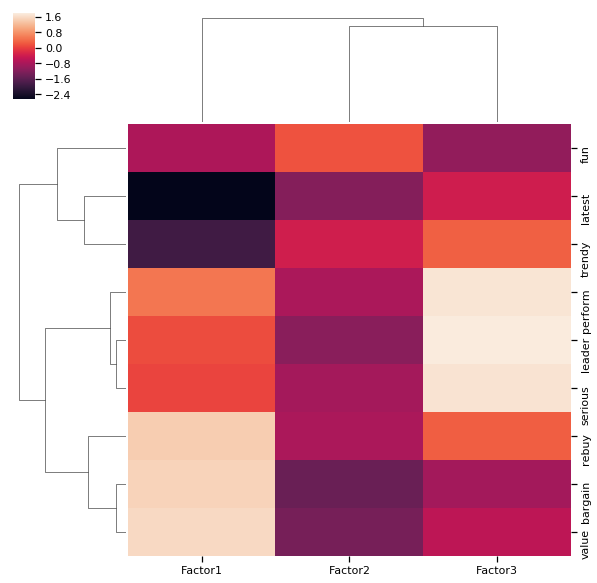

In [44]:
# Visualize the factor loading matrix
sns.clustermap(df_loadings)

### <font color="magenta">Q7. Can you describe the factors?</font>

__(YOUR INTERPRETATION HERE)__

There are a number of important concepts within factor analysis that are not covered here, including:
- _simple structure_ of factors
  - [reference](http://www.ats.ucla.edu/stat/spss/output/factor1.htm)
  - [reference](https://en.wikipedia.org/wiki/Factor_analysis#Rotation_methods)
- rotation (varimax, promax, ...)
  - [strategy for selecting a rotation](http://jalt.org/test/PDF/Brown31.pdf)
- orthogonal and oblique factors
- determining the number of components in EFA
- confirmatory factor analysis (CFA)

# 4. Manifold Learning

So far the dimensionality reduction methods we have studied are linear in nature. If the actual data points are distributed on a low-dimensional non-linear manifold living in a high-dimensional space, then linear methods will most likely fail to reveal the most intuitive structures of the data. This means we will see "a mess" in our low-dimensional visualization while the actual data actually has a very simple and elegant non-linear (e.g., curved) structure. 

In such situations where linear models face troubles, we can use manifold learning to do non-linear dimensionality reduction. 


## 4.1 Multidimensional Scaling (MDS)
MDS seeks a low-dimensional representation of the data that preserves the distances in the high-dimensional space. It can take any kind of distance matrix as input.

Note that each time you run MDS, you will get a different result, unless `random_state` is fixed.

### <font color="magenta">Q8. Create a MDS representation</font>

In [45]:
### YOUR CODE HERE ###

In [46]:
# Use MDS to visualize *brands*.
# Recall that df_bybrand is the mean-metric-by-brand 
# we created above.


__(YOUR INTERPRETATION HERE)__

## 4.2  t-distributed Stochastic Neighbor Embedding (t-SNE)
t-SNE is not a new technique, but rather one that has recently come into
fashion, partly as a result of access to more powerful computing resources.
t-SNE is similar to MDS.  If you have time, repeat the work you did in exercise 4.1 using ```sklearn.manifold.TSNE``` instead of MDS.  Please see t-SNE documentation at http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html


### <font color="magenta">Q9. Create a t-SNE representation</a>

In [47]:
### YOUR CODE HERE ###

In [48]:
# Use t-SNE to visualize *brands*.


__(YOUR INTERPRETATION HERE)__